In [ ]:
#default_exp simclr

# SimCLR

> [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Data Augmentation

We can use batch data augmentation utilities form `self_supervised.augmentations` module.

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

SimCLR augmentations side by side with the original image

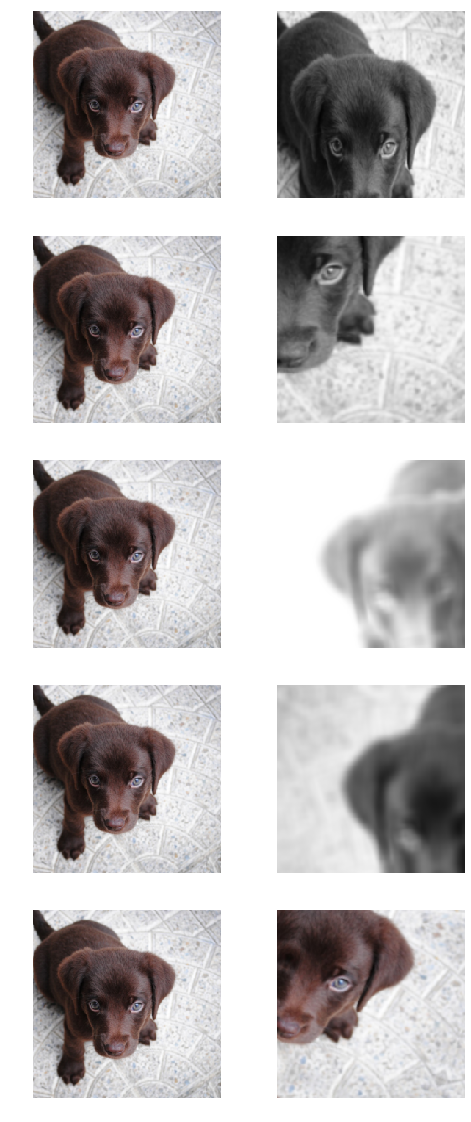

In [ ]:
aug = get_batch_augs(224, cuda=False)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/simclr.png)

For encoder any PyTorch model which takes an image input and outputs embeddings/representations can be used. You can also use utilities to create encoder from the models defined in `fastai` or `timm` using the following functions: `create_fastai_encoder` and `create_timm_encoder`. Fastai expects a function such as `xresnet18` as first argument whereas timm expects a string like `"tf_efficientnet_b0_ns"`.

In [ ]:
timm_encoder = create_timm_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False)

In [ ]:
L(timm_encoder.named_children())[-4:].itemgot(1)

(#4) [BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),SiLU(inplace=True),SelectAdaptivePool2d (pool_type=avg, flatten=True),Identity()]

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=3, pretrained=False, concat_pool=True)

In [ ]:
L(fastai_encoder.named_children())[-3:].itemgot(1)

(#3) [Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idpath): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): ReLU(inplace=True)
  )
  (1): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

For creating MLP module aka projector `create_mlp_module` can be used.

In [ ]:
#export
class SimCLRModel(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

In [ ]:
my_projector = create_mlp_module(1280, 1024, 128, bn=True, nlayers=2); my_projector

Sequential(
  (0): Linear(in_features=1280, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=1024, out_features=128, bias=True)
)

In [ ]:
model = SimCLRModel(timm_encoder, my_projector)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

You can either use `SimCLRModel` module to create a model by passing predefined `encoder` and `projector` models or you can use `create_simclr_model` with just passing predefined encoder and expected input channels.

In [ ]:
#export
def create_simclr_model(encoder, n_in=3, hidden_size=256, projection_size=128):
    "Create SimCLR model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size) 
    apply_init(projector)
    return SimCLRModel(encoder, projector)

In [ ]:
model = create_simclr_model(timm_encoder, n_in=3, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## SimCLR Callback

In [ ]:
#export
def remove_diag(x):
    bs = x.shape[0]
    return x[~torch.eye(bs).bool()].reshape(bs,bs-1)

class SimCLRLoss(Module):
    "SimCLR loss function"
    def __init__(self, temp=0.1):
        self.temp = temp
        
    def forward(self, inp, targ):
        bs,feat = inp.shape
        csim = F.cosine_similarity(inp, inp.unsqueeze(dim=1), dim=-1)/self.temp
        csim = remove_diag(csim)
        targ = remove_diag(torch.eye(targ.shape[0], device=inp.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(csim, targ)

Loss function allows you to specify `temp` which is the temperature parameter to be used in cross entropy loss. It calculates cosine similarity of different views of the same image to be used as the prediction

In [ ]:
x = torch.randn(16,128)
y = torch.arange(16).roll(16//2)
loss_func = SimCLRLoss(temp=0.1)
loss_func(x,y)

tensor(3.1385)

In [ ]:
#export
class SimCLR(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        print(self.aug1); print(self.aug2)
                    
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

You can pass `size` to define the random resized crop size and other data augmentation arguments defined in `aug_func` through `aug_kwargs`. Also, with `show_one()` method you can inspect data augmentations as a sanity check. You can use existing augmentation functions from `augmentations` module.

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_simclr_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model, SimCLRLoss(temp=0.5),
                cbs=[SimCLR(size=28, aug_func=get_batch_augs, 
                            rotate=False, jitter=False, bw=False, blur=False,
                            stats=None, cuda=False),
                     ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


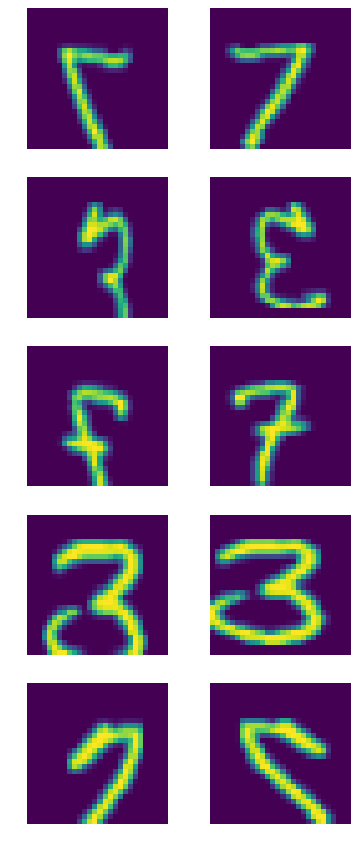

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(2.4161)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
